**Heuristics for the single-depot VRP:**
This Single-Depot Vehicle Routing Problem notebook is based on the "Savings" Algorithm of Clarke and Wright. It is a greedy but efficient approach to solve this complex optimization problem.

Consider a depot $D$ and $n$ demand points. Suppose that initially the solution to the VRP consists of using $n$ vehicles and dispatching one vehicle to each one of the $n$ demand points. The total tour length of this solution is: $2 \sum_{i=1}^n d(D, i)$.

If now we use a single vehicle to serve two points, say $i$ and $j$, on a single trip, the total distance traveled is reduced by the amount:

$$s(i,j) = 2d(D, i) + 2d(D, j) - [d(D, i) + d(i, j) + d(D,j)]$$ $$=d(D, i) + d(D, j) - d(i, j)$$

The quantity $s(i,j)$ is known as the "savings" resulting from combining points $i$ and $j$ into a single tour. The larger $s(i, j)$ is, the more desirable it becomes to combine $i$ and $j$ in a single tour. However, $i$ and $j$ cannot be combined if in doing so the resulting tour violates one or more of the constraints of the VRP.

Reference: https://web.mit.edu/urban_or_book/www/book/chapter6/6.4.12.html

In [1]:
import pandas as pd
from itertools import combinations
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

# Define Custom Parameters

In [2]:
# Maximum number of visits for each route:
max_visits = 4

# Load and Process Data

In [3]:
# Load Raw Data

# Randomly generate 50 locations:
import numpy as np
n = 50
raw = pd.DataFrame(np.random.rand(n, 2) * 100, columns=['x','y'])
raw.iloc[0]['x'] = 50
raw.iloc[0]['y'] = 50

In [4]:
# Data Pre-processing

data = raw

# Visualize Locations

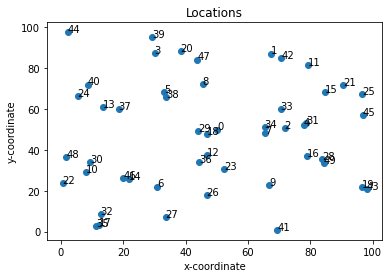

In [5]:
fig, ax = plt.subplots()
ax.scatter(data['x'], data['y'])
plt.title("Locations")
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")

for i in data.index:
    ax.annotate(i, (data.iloc[i]['x'], data.iloc[i]['y']))

# Algorithm - Step 1

Compute Distance Matrix with Node 0 set as the depot:

In [6]:
# distance_matrix() returns a matrix containing distance from every vector in x to every vector in y
dist_matrix = np.round(distance_matrix(x=data.values, y=data.values),2)

# Algorithm - Step 2

Compute Ranked Savings for all Node pairs except Node 0 (i.e. depot):

In [7]:
node_pairs = {}
for i in range(1, dist_matrix.shape[0]):
    for j in range(i+1, dist_matrix.shape[1]):
        saving = dist_matrix[0,i] + dist_matrix[0,j] - dist_matrix[i,j]
        node_pairs[(i,j)] = saving

node_pairs_sorted = sorted(node_pairs.items(), key = lambda x: x[1], reverse=True)
df = pd.DataFrame.from_dict(node_pairs_sorted)
print('Top 10 Node Pairs w.r.t. Savings:')
display(df[:10])

Top 10 Node Pairs w.r.t. Savings:


,0,1
0,"(17, 35)",120.49
1,"(32, 35)",111.16
2,"(17, 32)",110.87
3,"(19, 43)",108.71
4,"(22, 35)",93.82
5,"(10, 22)",93.60
6,"(22, 48)",93.33
7,"(17, 22)",92.90
8,"(22, 32)",92.55
9,"(39, 44)",89.95


# Algorithm Step 3a: Building Blocks

## Condition 1: Neither $i$ nor $j$ already assigned to a route

In [8]:
def condition1(routes, i, j):
    i_assigned = False
    j_assigned = False

    for r in routes:
        if i in r:
            i_assigned = True
        if j in r:
            j_assigned = True
        else:
            continue

    if i_assigned == True or j_assigned == True:
        return False # Either i or j or both assigned
    else:
        return True # Neither i nor j assigned

## Condition 2: Exactly one of $i$ or $j$ assigned to a route AND that $i$ or $j$ is not interior

In [9]:
def condition2(routes, i, j):
    i_assigned = False
    j_assigned = False

    i_interior = False
    j_interior = False

    for idx, r in enumerate(routes):
        if i in r:
            i_assigned = True
            if r[1] != i and r[-2] != i:
                i_interior = True
            else:
                route_idx_i = idx
        if j in r:
            j_assigned = True
            if r[1] != j and r[-2] != j:
                j_interior = True
            else:
                route_idx_j = idx
        else:
            continue

    if i_assigned != j_assigned: # Exactly one of i or j assigned to a route
        if i_assigned == True:
            if i_interior == False:
                return route_idx_i, True # Both conditions hold for i
            else:
                return None, False # i is assigned AND is interior
        else:
            if j_interior == False:
                return route_idx_j, True # Both conditions hold for j
            else:
                return None, False # j is assigned AND is interior
    else:
        return None, False # Either both assigned or both unassigned

## Condition 3: Both $i$ and $j$ assigned to different routes AND neither $i$ nor $j$ is interior to its route

In [10]:
def condition3(routes, i, j):
    i_assigned = False
    j_assigned = False

    i_interior = False
    j_interior = False

    for idx, r in enumerate(routes):
        if i in r and j in r:
            return None, None, False # i and j assigned to the same route
        else:
            if i in r:
                i_assigned = True
                if r[1] != i and r[-2] != i:
                    i_interior = True
                else:
                    route_idx_i = idx
            if j in r:
                j_assigned = True
                if r[1] != j and r[-2] != j:
                    j_interior = True
                else:
                    route_idx_j = idx
            else:
                continue

    if i_assigned == True and j_assigned == True:
        if i_interior == False and j_interior == False:
            return route_idx_i, route_idx_j, True # Both conditions hold for i and j
        else:
            return None, None, False # i, j assigned to different routes but one or both are interior
    else:
        return None, None, False # Required conditions do not hold for i and j

## Additional Custom Functions

Find nodes not assigned to any routes:

In [11]:
def missing_nodes(df, routes):
    init_nodes = set()
    out_nodes = set()
    
    for link in range(len(df)):
        init_nodes = init_nodes.union(df.iloc[link][0])

    for route in routes:
        out_nodes = out_nodes.union(route)

    return init_nodes - out_nodes

Compute total distance traveled and total savings:

In [12]:
def total_dist_savings(dist_matrix, df, routes):
    
    # Combinations of routes:
    pairs = []
    for route in routes:
        if len(route) > 3:
            pairs += list(combinations(sorted(route[1:-1]), 2))
        else:
            pairs += list(combinations(sorted(route[:-1]), 2))

    total_savings = df[df[0].isin(pairs)][1].sum()
    
    total_distance = 0.
    
    for (i,j) in pairs:
        total_distance += dist_matrix[i,j]
        
    return total_distance, total_savings

# Algorithm - Step 3b: Run the model

In [13]:
# Prepare routes as a list of lists:
routes = []

for link in range(len(df)):
    i, j = df.iloc[link][0]
    
    # Evaluate Conditions:
    c1 = condition1(routes, i, j)
    idx, c2 = condition2(routes, i, j)
    idx1, idx2, c3 = condition3(routes, i, j)

    if c1 == True:
        # Initiate new route including link (i,j)
        routes.append([0, i, j, 0])

    elif c2 == True:
        # Add link (i,j) to the same route
        route = routes[idx]
        if i not in route and len(route) < max_visits+2:
            # Is j in the beginning or in the end of the route?
            if route[1] == j:
                new = [0, i]
                new += route[1:]
                routes[idx] = new
            else:
                new = route[:-1]
                new += [i, 0]
                routes[idx] = new
        elif j not in route and len(route) < max_visits+2:
            # Is i in the beginning or in the end of the route?
            if route[1] == i:
                new = [0, j]
                new += route[1:]
                routes[idx] = new
            else:
                new = route[:-1]
                new += [j, 0]
                routes[idx] = new
        else:
            # Max limit of a route reached so can't add another node
            continue

    elif c3 == True:
        # Merge the two routes containing i and j
        route1 = routes[idx1]
        route2 = routes[idx2]

        combined_visits = len(route1[1:-1]) + len(route2[1:-1])

        if combined_visits <= max_visits:
            new = [0]
            new += route1[1:-1]
            new += route2[1:-1]
            new += [0]

            new_routes = []
            for ind, r in enumerate(routes):
                if ind not in {idx1, idx2}:
                    new_routes.append(r)

            new_routes.append(new)

            routes = new_routes
        else:
            # Merged route exceeds Max limit so can't merge
            continue

    else:
        # None of the three conditions hold.
        continue

# Add individual left-over routes:
missing = missing_nodes(df, routes)

for node in missing:
    new_route = [0, node, 0]
    routes.append(new_route)

distance, savings = total_dist_savings(dist_matrix, df, routes)

# Model Output

In [14]:
print('Total No. of Routes found:', len(routes))
print('\nRoutes Generated:')
for i, r in enumerate(routes):
    print(i, ': ', r, sep='', end='\n')
print('\nTotal Distance Traveled:', round(distance,1))
print('\nTotal Savings:', round(savings,1))

Total No. of Routes found: 13

Routes Generated:
0: [0, 27, 17, 35, 32, 0]
1: [0, 19, 43, 49, 28, 0]
2: [0, 10, 22, 48, 30, 0]
3: [0, 39, 44, 40, 24, 0]
4: [0, 15, 21, 25, 45, 0]
5: [0, 1, 42, 11, 33, 0]
6: [0, 5, 3, 20, 47, 0]
7: [0, 36, 6, 14, 46, 0]
8: [0, 8, 38, 13, 37, 0]
9: [0, 16, 9, 41, 26, 0]
10: [0, 2, 4, 31, 34, 0]
11: [0, 29, 12, 23, 7, 0]
12: [0, 18, 0]

Total Distance Traveled: 1167.1

Total Savings: 4323.4


# Visualize Routes:

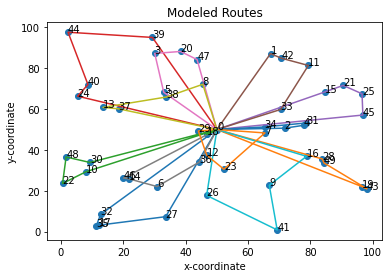

In [15]:
fig, ax = plt.subplots()
ax.scatter(data['x'], data['y'])
plt.title("Modeled Routes")
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")

for i in data.index:
    ax.annotate(i, (data.iloc[i]['x'], data.iloc[i]['y']))

for r in routes:
    sub_df = data.iloc[r]
    ax.plot(sub_df['x'], sub_df['y'], '-')